# Visualization of Forecasting Model Predictions

This notebook is designed to load a trained forecasting model, run it on a test dataset, and visualize the model's predictions alongside ground truth values.


## 1. Setup Python Path for Imports


In [1]:
%load_ext autoreload
%autoreload 2

# 1. Setup Python path for imports
import sys
import os

import matplotlib.pyplot as plt
import numpy as np

# Adjust this to your project root directory
project_root = os.path.abspath("/home/s223669184/timeseries-study-suite")

if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root added to sys.path: {project_root}")

Project root added to sys.path: /home/s223669184/timeseries-study-suite


# 2. Import Required Modules and Define Paths
Import PyTorch, the model class (currently RNNForecast), and the testing function. Define paths to your test dataset and model checkpoint.

In [2]:
# 2. Imports
import torch
from models.classic.rnn import RNNForecast
from models.classic.transformer import TransformerForecast
from test_scripts.test import test_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
test_csv_path = os.path.join(project_root, "data/processed/ETTh1/test.csv")
gru_checkpoint_path = "/scratch/s223669184/timeseries-study-suite/checkpoints/rnn_gru_etth1.pt"
lstm_checkpoint_path = "/scratch/s223669184/timeseries-study-suite/checkpoints/rnn_lstm_etth1.pt"
transformer_checkpoint_path = "/scratch/s223669184/timeseries-study-suite/checkpoints/transformer_etth1.pt"

## 3. Test Model


### 3.1 LSTM

In [4]:
# Initialize model (match training hyperparams)
lstm = RNNForecast(
    input_dim=6,
    hidden_dim=128,           # match checkpoint
    output_dim=1,
    num_layers=3,
    rnn_type="lstm",           # match checkpoint
    dropout=0.1,  
    bidirectional=True        # match checkpoint
).to(device)

# Run test and get preds, targets
lstm_preds, lstm_targets, mse, mae = test_model(
    model=lstm,
    test_path=test_csv_path,
    checkpoint_path=lstm_checkpoint_path,
    input_len=96,
    pred_len=1,
    batch_size=64,
    device=device
)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")


Loaded model checkpoint from '/scratch/s223669184/timeseries-study-suite/checkpoints/rnn_lstm_etth1.pt'
Test MSE: 0.688757
Test MAE: 0.779117


### 3.2 GRU

In [5]:
# Initialize model (match training hyperparams)
gru = RNNForecast(
    input_dim=6,
    hidden_dim=128,           # match checkpoint
    output_dim=1,
    num_layers=3,
    rnn_type="gru",           # match checkpoint
    dropout=0.1,  
    bidirectional=True        # match checkpoint
).to(device)

# Run test and get preds, targets
gru_preds, gru_targets, mse, mae = test_model(
    model=gru,
    test_path=test_csv_path,
    checkpoint_path=gru_checkpoint_path,
    input_len=96,
    pred_len=1,
    batch_size=64,
    device=device
)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")


Loaded model checkpoint from '/scratch/s223669184/timeseries-study-suite/checkpoints/rnn_gru_etth1.pt'
Test MSE: 0.738680
Test MAE: 0.763142


### 3.3 Transformer

In [7]:
# Initialize model (match training hyperparams)
transformer = TransformerForecast(
    input_dim=6,
    hidden_dim=128,           # match checkpoint
    output_dim=1,
    num_layers=3,
    nhead=4,
    dropout=0.1,
    dim_feedforward=512,
    use_pos_encoding=True
).to(device)

# Run test and get preds, targets
transformer_preds, transformer_targets, mse, mae = test_model(
    model=transformer,
    test_path=test_csv_path,
    checkpoint_path=transformer_checkpoint_path,
    input_len=96,
    pred_len=1,
    batch_size=64,
    device=device
)

print(f"Test MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")


Loaded model checkpoint from '/scratch/s223669184/timeseries-study-suite/checkpoints/transformer_etth1.pt'
Test MSE: 0.496210
Test MAE: 0.569243


## 4. Visualize Predictions vs Ground Truth on ETTH1


### 4.1 Denormalized the Predictions

In [8]:
etth1_train_stats = {
    'x_mean': [0.009869, -0.139674, 0.036506, -0.103898, -0.128803, -0.127520],
    'x_std': [0.898649, 1.034665, 0.901914, 1.065443, 1.020725, 1.104933],
    'y_mean': 16.29471486647764,
    'y_std': 8.34847203863057,
    'feature_names': ['HUFL', 'HULL', 'MUFL', 'MULL', 'LUFL', 'LULL']
}

In [10]:
# Denormalize using training stats
y_mean = etth1_train_stats['y_mean']
y_std = etth1_train_stats['y_std']

gru_preds_denorm = gru_preds * y_std + y_mean
lstm_preds_denorm = lstm_preds * y_std + y_mean
transformer_preds_denorm = transformer_preds * y_std + y_mean
targets_denorm = gru_targets * y_std + y_mean


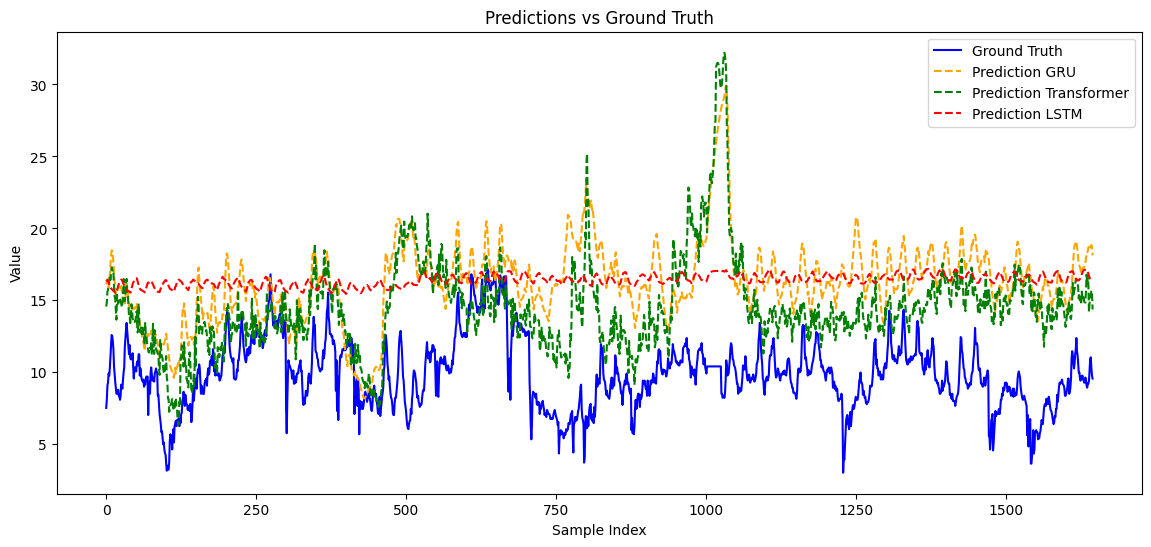

In [11]:
plt.figure(figsize=(14, 6))
plt.plot(targets_denorm, label="Ground Truth", color="blue")
plt.plot(gru_preds_denorm, label="Prediction GRU", color="orange", linestyle="--")
plt.plot(transformer_preds_denorm, label="Prediction Transformer", color="green", linestyle="--")
plt.plot(lstm_preds_denorm, label="Prediction LSTM", color="red", linestyle="--")


plt.title("Predictions vs Ground Truth")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.legend()
plt.show()